### UK Road Accident Time Series Forecasting 

This project entails combining statistical models and machine learning / deep learning models to forecast the number of casualties (or accident rates) for year 2015 and 2016 based on the 2005 - 2014 UK Road Accident Dataset. 




- **The aim is to use statistical and machine learning models to forecast the number of casualties due to road accidents 2 years into the future based on the available dataset, also this project entails experimenting on the different kinds of Long-Short Term Memory (LSTM) Neural Networks (i.e. LSTM, GRU - Gated recurrent units, Bidirectional LSTM and Convolutional LSTM) and trying to see if they can learn from the small time series dataset.**




- For this project we will use the following models for forecasting:
    
    - SARIMA (Seasonal - Autoregressive Integrated Moving Average)
    - Facebook Prophet 
    - LSTM:
      - LSTM
      - GRU
      - Bidirectional LSTM
      - Convolutional LSTM
      
      
      
- [Dataset Download link](https://www.kaggle.com/daveianhickey/2000-16-traffic-flow-england-scotland-wales)
     


In [6]:
import math 
import calendar
import datetime
import pmdarima as pm

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline


#import necessary libraries
import keras
import os
from sklearn.preprocessing import StandardScaler
import seaborn as sns
sns.set_style("darkgrid")
import matplotlib.pyplot as plt
%matplotlib inline


from fbprophet import Prophet
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from scipy.interpolate import interp1d
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as smt

from numpy.random import seed
from datetime import datetime

from keras import optimizers, Sequential
from keras.layers import Input, Dropout
from keras.layers.core import Dense 
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Bidirectional, GRU
from keras.models import Model, Sequential, load_model
from keras import regularizers
from keras.models import model_from_json
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Flatten
from keras.layers import ConvLSTM2D
import warnings
warnings.filterwarnings("ignore")
from statsmodels.multivariate.manova import MANOVA



# plotly
from fbprophet.plot import plot_plotly
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly import tools
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode()

ModuleNotFoundError: No module named 'pmdarima'

In [5]:
#load in datasets
uk_2007 = pd.read_csv('./uk-data/accidents_2005_to_2007.csv', low_memory=False)
uk_2011 = pd.read_csv('./uk-data/accidents_2009_to_2011.csv', low_memory=False)
uk_2014 = pd.read_csv('./uk-data/accidents_2012_to_2014.csv', low_memory=False)

NameError: name 'pd' is not defined

In [2]:
type(uk_2017)

NameError: name 'uk_2017' is not defined

In [3]:
#concatenate the three datasets
uk_accidents = pd.concat([uk_2007, uk_2011, uk_2014], ignore_index=True)

In [4]:
uk_accidents.shape

(1504150, 33)

In [5]:
#Number of nulls by each columns
uk_accidents.isnull().sum()

Accident_Index                                       0
Location_Easting_OSGR                              101
Location_Northing_OSGR                             101
Longitude                                          101
Latitude                                           101
Police_Force                                         0
Accident_Severity                                    0
Number_of_Vehicles                                   0
Number_of_Casualties                                 0
Date                                                 0
Day_of_Week                                          0
Time                                               117
Local_Authority_(District)                           0
Local_Authority_(Highway)                            0
1st_Road_Class                                       0
1st_Road_Number                                      0
Road_Type                                            0
Speed_limit                                          0
Junction_D

In [6]:
#drop columns with greater than 10,000 null values
uk_accidents = uk_accidents.drop(['Junction_Detail', 'Junction_Control', 'LSOA_of_Accident_Location'], axis=1)

In [7]:
uk_accidents.dropna(inplace = True)

In [8]:
uk_accidents.head(5)

,Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,...,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,Year
0,200501BS00001,525680.0,178240.0,-0.191170,51.489096,1,2,1,1,04/01/2005,...,None within 50 metres,Zebra crossing,Daylight: Street light present,Raining without high winds,Wet/Damp,None,None,1,Yes,2005
1,200501BS00002,524170.0,181650.0,-0.211708,51.520075,1,3,1,1,05/01/2005,...,None within 50 metres,Pedestrian phase at traffic signal junction,Darkness: Street lights present and lit,Fine without high winds,Dry,None,None,1,Yes,2005
2,200501BS00003,524520.0,182240.0,-0.206458,51.525301,1,3,2,1,06/01/2005,...,None within 50 metres,No physical crossing within 50 meters,Darkness: Street lights present and lit,Fine without high winds,Dry,None,None,1,Yes,2005
3,200501BS00004,526900.0,177530.0,-0.173862,51.482442,1,3,1,1,07/01/2005,...,None within 50 metres,No physical crossing within 50 meters,Daylight: Street light present,Fine without high winds,Dry,None,None,1,Yes,2005
4,200501BS00005,528060.0,179040.0,-0.156618,51.495752,1,3,1,1,10/01/2005,...,None within 50 metres,No physical crossing within 50 meters,Darkness: Street lighting unknown,Fine without high winds,Wet/Damp,None,None,1,Yes,2005


In [9]:
#columns with more than 100,000 None Values
none_columns = []
for x in uk_accidents.columns:
    none_ct = uk_accidents[x].loc[uk_accidents[x] == 'None'].count()
    if none_ct >= 100000:
        none_columns.append(x)

In [10]:
print(none_columns)

['Special_Conditions_at_Site', 'Carriageway_Hazards']


In [11]:
uk_accidents = uk_accidents.drop(none_columns, axis=1)

In [12]:
uk_accidents.shape

(1499500, 28)

In [13]:
#convert all datetime columns to datetime formats
df_uk = uk_accidents.copy()
df_uk['Date'] = pd.to_datetime(df_uk['Date'])
df_uk['Year'] = df_uk['Date'].dt.year
df_uk['month_year'] = df_uk['Date'].dt.strftime('%Y-%m')
df_uk['month'] = df_uk.Date.dt.month

 **Note: For this project, No exploratory or Descriptive analysis was done, All analysis regarding the accident rates in UK can be found in the `UK_road_accident_analytics.ipynb`**

### 1.  SARIMA - Forecast UK Accident rates based on Number of Casualties

In [22]:
uk_df = df_uk[['Date', 'Number_of_Casualties']].copy()

In [23]:
##aggregate Number of Casualties by "each Day of Occurence"
df_uk_agg = uk_df.groupby(['Date']).Number_of_Casualties.agg(['sum']).sort_values(by = 'Date')

In [24]:
#resampling (aggregating the dates) for each month
uk_agg = df_uk_agg['sum'].resample('MS').agg(['mean'])

In [17]:
uk_agg.head()

,mean
Date,
2005-01-01,757.000000
2005-02-01,696.821429
2005-03-01,653.064516
2005-04-01,738.000000
2005-05-01,747.258065


In [18]:
def plot_accident_rate(df, title):
    fig = go.Figure(go.Scatter(x = df.index, y = df['mean'], mode='lines+markers', name = 'Number of Casualties',
                               line= dict(color = ('crimson'), width=2), showlegend = True))
    fig.update_layout(title_text="<b> Accident rates in UK, (" + title + ")<b>", 
                      xaxis_title="<b> Date <b>", yaxis_title="<b> Monthly Average <b>", 
                      font=dict(size=12, color="darkslategray"))
    
    fig.update_xaxes(rangeslider_visible=True, rangeselector=dict(buttons=list([
        dict(count=1, label="1m", step="month", stepmode="backward"), 
        dict(count=6, label="6m", step="month", stepmode="backward"),
        dict(count=1, label="YTD", step="year", stepmode="todate"), 
        dict(count=1, label="1y", step="year", stepmode="backward"), dict(step="all")])))
    fig.show()

In [19]:
plot_accident_rate(uk_agg, '2008 == Missing Gap')

In [20]:
##lets interpolate for the whole year of 2008, since 2008 is missing
##i also tried cubic and spline (order= 2, 3) they gave similar reselts
uk_agg = uk_agg.interpolate(method = 'quadratic').asfreq('MS')

In [21]:
plot_accident_rate(uk_agg, 'Other types of Interpolation')

***I chose linear interpolation because it is more consistent (even though it didnt depicts the variations we had expect for the year 2008) than other types of interpolation, Interpolation from other types (quadratic, cubic, spline) all resulted in a huge DIP for the year 2008 which is not to expected for the DATA for that year.***

In [25]:
##lets interpolate for the whole year of 2008, since 2008 is missing
uk_agg = uk_agg.interpolate(method = 'linear').asfreq('MS')

In [26]:
plot_accident_rate(uk_agg, 'After Linear Interpolation')

In [27]:
uk_agg.shape

(120, 1)

In [28]:
##TEST AND TRAIN DATA

df_train_uk = uk_agg.loc[:'2014-01-01']
df_test_uk = uk_agg.loc['2014-01-01':]

#### What is SARIMA?

 - SARIMA -- Seasonal (S) AutoRegressive Integrated Moving Average (ARIMA).
 
 

SARIMA are ARIMA models with seasonal component that are used in **fitting time series data,** to help in getting a better understanding of the data or to make predictions i.e. forecast into the nearest future based on the previous or current values.





- The seasonal component of ARIMA takes into account the seasonality of yout time series data, SARIMA is used only if your data has **defined seasonality.**





- ARIMA Components:
  - AR - Auto-Regressive -- An autoregressive model is when a value from a time series is regressed on previous values from that same time series i.e. previous values  of the same variable become the predictor for the next value. for example, yt on yt−1:    yt=β0+β1yt−1+ϵt. [read more](https://online.stat.psu.edu/stat501/lesson/14/14.1#:~:text=An%20autoregressive%20model%20is%20when,from%20that%20same%20time%20series.&text=The%20order%20of%20an%20autoregression,value%20at%20the%20present%20time.)
  
  
  
  
  
  - I - Integrated -- means time series data that would be given to the **model** needs to be differenced to be made **stationary** in order to be an "integrated" version of a stationary series. if the time series data is already stationary, NO need for differencing.
  
  
  
  
  
  - What does mean for a time series Data to be Stationary?
     - A stationary time series data has no trend, its variations around its mean is constant over time, its autocorrelation (correlations with its previous values) remain constant over time, also has constant variance over time with no periodic component.
     
     
     
     
     
  - MA - Moving Average -- a moving average model uses past forecast errors in a regression-like model. In ARIMA, the forecast values depend on the **lagged forecast errors, i.e. Inaccuracies of the autoregressive models of the respective lags are used to explain the autocorrelation pattern of the stationary time series data.**
  
  
  
***Note: Time Gap between a previous and a future/next value is called LAG.***





 - SARIMA model Formula: -- SARIMA(p,d,q,)S(P,D,Q)::
 
 
   
   - p -- Order of an autoregression is the number of immediately preceding values in the series that are used to predict the value at the present time. It is usually refer to as the Lag of the stationarized series called **“autoregressive” (AR) terms.**
   
   
   
   - P -- seasonal p (i.e. has the same meaning as "p", the **only difference** is the seasonal **"S"** component **multiplied to it**), which means the number of preceding seasons used to predict the next season value.
   
   
   
   - d -- is the number of nonseasonal differences needed to make a time series data stationary.
   
   
   
   - D -- is the number of **Seasonal differences** needed to make a **seasonal time series data stationary.**
   
   
   
   - q -- is the **number of lagged forecast errors** needed to explain autocorrelation pattern in a **non-seasonal** stationary time series data.
   
   
   
   - Q -- is the **number of lagged forecast errors** needed to explain autocorrelation pattern in a **Seasonal** stationary time series data. This is achieved by multplying the **seasonal S** with P term.
   
   
   
   - S -- **Seasonal component of the ARIMA.** this means number of time steps for a single seasonal period.
   
   
   ***Resources Used:***
   
   [resource 1](https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/)::
   [resource 2](https://www.machinelearningplus.com/time-series/time-series-analysis-python/)
   [resource 3](https://people.duke.edu/~rnau/411arim3.htm)
   [resource 4](https://online.stat.psu.edu/stat501/lesson/14/14.1#:~:text=An%20autoregressive%20model%20is%20when,from%20that%20same%20time%20series.&text=The%20order%20of%20an%20autoregression,value%20at%20the%20present%20time.)
   [resource 5](https://machinelearningmastery.com/sarima-for-time-series-forecasting-in-python/)
   


### Check Time series pattern


- Any time series may be split into the following components: **Base Level + Trend + Seasonality + Error.**



  - A trend is observed when there is an increasing or decreasing slope observed in the time series. Whereas seasonality is observed when there is a distinct repeated pattern observed between regular intervals due to seasonal factors.
  
  
  -- Lets check if our time series data has either one of the them or both.
  
  
  --- I will be using ***multiplicative combination of the base level, trend, seasonal index and the residual*** to check the time series pattern in our dataset. 
  
  
  
  **Note: a multiplicative decomposition assumes the aforementioned components are combined through multiplication.**


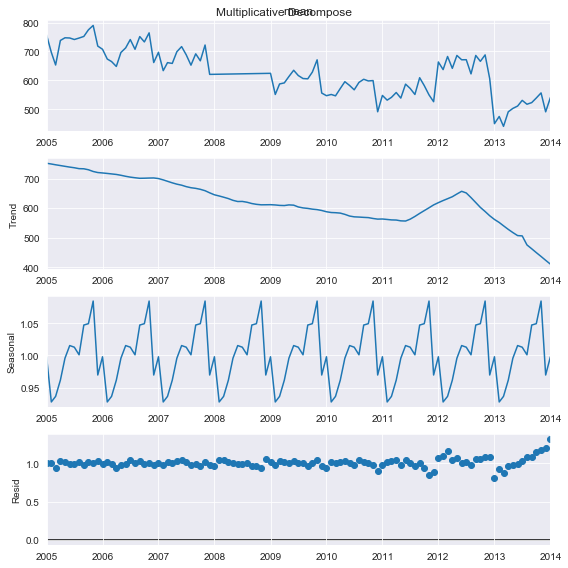

In [29]:
# Multiplicative Decomposition 
result_mul = seasonal_decompose(df_train_uk['mean'], model='multiplicative', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (8,8)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=12)
plt.show()

As observed from the decomposition diagram, our time series data exhibit ***repeated seasonal pattern*** and also has ***a trend sloping down from 2005 to around 2012 before huge spike in 2012 and a further downward pattern.***

### Next Check if our Time Series Data is "Stationary or Non-Stationary"



-- For this we will be using **Augmented Dickey Fuller test (ADH Test)**

-- For ADF test, It is stated that the **null hypothesis** indicates that the time series possesses a unit root and is **non-stationary.** 

So, if the P-Value in ADH test is less than the significance level (0.05), you reject the null hypothesis, and if not then, you have to difference your data, to make it stationary.

In [30]:
# ADF Test
result = adfuller(df_train_uk['mean'].values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -2.1749475926575843
p-value: 0.21546333678837248


Based on the above ADH Test, the 2005 - 2014 time series data is **"NON-STATIONARY"** since p-value is greater than 0.05, i.e. IT REQUIRES DIFFERENCING (d) to make it stationary.

-- To get the aprropriate **"d"** this will be done later when **performing Grid Search on the SARIMA model**

#### - Plot autocorrelation function (ACF) and partial autocorrelation function (PACF)  to determine the AR (Autoregressive) and MA (Moving Average) terms for our ARIMA model

- What is Autocorrelation Function?
  - The coefficient of correlation between two values in a time series is called the autocorrelation function (ACF).
  - The ACF is a way to measure the linear relationship between an observation at time t and the observations at previous times. 
  
  
- What is Partial autocorrelation?
  - In general, the "partial" correlation between two variables is the amount of correlation between them which **is not explained by their mutual correlations with a specified set of other variables.** For example, if we are regressing a variable Y on other variables X1, X2, and X3, **the partial correlation between Y and X3 is the amount of correlation between Y and X3 that is not explained by their common correlations with X1 and X2.**
  
  
#### What do they do:


  
- The PACF tells you how many AR terms are likely be needed to explain or remove any autocorrelation pattern from a stationarized series.

- Sometimes it is more efficient to add MA terms (lags of the forecast errors) instead. The autocorrelation function (ACF) plays the same role for MA terms that the PACF plays for AR terms--that is, the ACF tells you how many MA terms are likely to be needed to remove the remaining autocorrelation from the differenced series. 

[Reference](https://people.duke.edu/~rnau/411arim3.htm):::::[Reference2](https://online.stat.psu.edu/stat501/lesson/14/14.1#:~:text=An%20autoregressive%20model%20is%20when,from%20that%20same%20time%20series.&text=The%20order%20of%20an%20autoregression,value%20at%20the%20present%20time.)

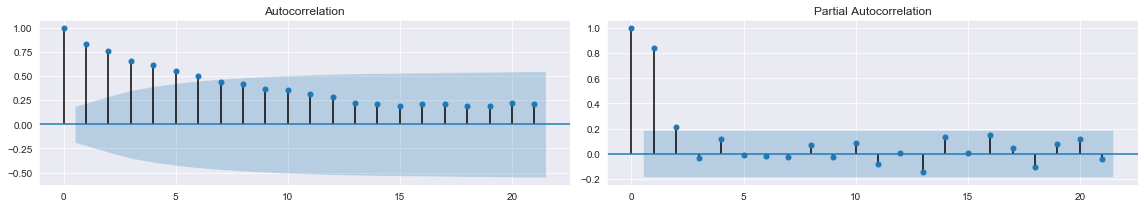

In [31]:
##GET THE VALUES FOR "ORDER OF AUTOREGRESSION -- P" AND "MOVING AVERAGE -- Q"
# Draw Plot
fig,axes = plt.subplots(1,2,figsize=(16,3))
smt.graphics.tsa.plot_acf(df_train_uk['mean'], ax=axes[0])
smt.graphics.tsa.plot_pacf(df_train_uk['mean'], ax=axes[1])
plt.tight_layout()

From the above plots, ACF plot shows us that about first 4 lags above the significant line, this means 4 MA terms may be needed for our SARIMA model, and 1 (since only the first lag is above significant line) AR term may be needed for our model.

- This appropriate terms will be set based performing **gridsearch on our SARIMA model**

#### - GRID SEARCH FOR THE BEST p, d, q VALUES

- pm.auto_arima() uses a stepwise approach to search multiple combinations of p,d,q parameters and chooses the best model that has the least AIC.

In [32]:
###GRID SEARCH FOR THE BEST P;D;Q VALUES FOR uk_TRAIN DATASET time series dataset
## Here we set maximum q == 4, maximum p == 2

model_uk = pm.auto_arima(df_train_uk['mean'], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=2, max_q=4, # maximum p and q
                      m=12,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # Set Seasonlity TRUE since, we have seasonality in our dataset
                      start_P=0, 
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

model_uk.summary()

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,1,1,12) [intercept=True]; AIC=981.885, BIC=994.706, Time=0.974 seconds
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=True]; AIC=1047.818, BIC=1052.947, Time=0.125 seconds
Fit ARIMA(1,1,0)x(1,1,0,12) [intercept=True]; AIC=1005.799, BIC=1016.056, Time=0.335 seconds
Fit ARIMA(0,1,1)x(0,1,1,12) [intercept=True]; AIC=980.338, BIC=990.595, Time=0.416 seconds
Near non-invertible roots for order (0, 1, 1)(0, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=False]; AIC=1045.884, BIC=1048.449, Time=0.125 seconds
Fit ARIMA(1,1,1)x(0,1,0,12) [intercept=True]; AIC=1045.181, BIC=1055.439, Time=0.233 seconds
Fit ARIMA(1,1,1)x(1,1,1,12) [intercept=True]; AIC=975.511, BIC=990.898, Time=0.913 seconds
Near non-invertible roots for order (1, 1, 1)(1, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  109
Model:             SARIMAX(0, 1, 1)x(0, 1, [1, 2], 12)   Log Likelihood                -481.256
Date:                                 Sat, 27 Jun 2020   AIC                            972.512
Time:                                         00:37:25   BIC                            985.333
Sample:                                              0   HQIC                           977.694
                                                 - 109                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2724      0.737      0.370      0.712      -1.171       1.716
ma.L1         -0.3363      0.091     -3.683      0.000      -0.515      -0.157
ma.S.L12      -1.2878      0.293     -4.402      0.000      -1.861      -0.714
ma.S.L24       0.3918      0.082      4.766      0.000       0.231       0.553
sigma2      1001.7811    309.377      3.238      0.001     395.414    1608.148
===================================================================================
Ljung-Box (Q):                       17.74   Jarque-Bera (JB):               129.78
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               3.81   Skew:                             0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

From the above table, the best SARIMA(p,d,q)(P,D,Q,M) Model == **SARIMAX(0, 1, 1)x(0, 1, [1, 2], 12).**





Note: This model is optimized towards achieving the lowest **AIC.**


- What is AIC?

  - The Akaike Information Critera (AIC) is a widely used measure of a statistical model. It basically quantifies 1) the goodness of fit, and 2) the simplicity/parsimony, of the model into a single statistic.
  
  
  - **Aho et al. [2014] discussed the use of AIC and Bayesian information criteria (BIC) for model selection. They conclude that AIC is a tool for picking a model that is most accurate in predicting out-of-sample data. When using AIC, we are not focused on selecting the correct model, but a model that is adequate for prediction. Thus, BIC is an instrument for selecting the correct model. When using BIC, we assume that the correct model is among the candidate models.**

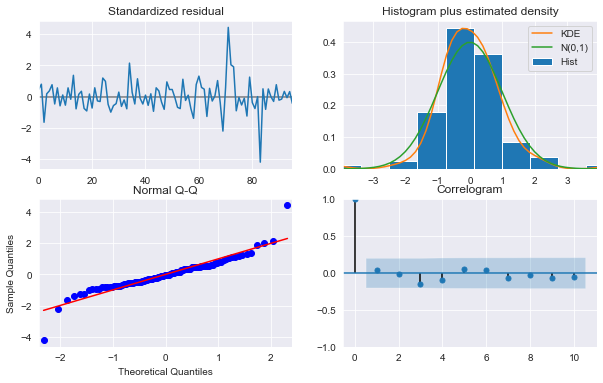

In [33]:
##check the accuracy of the linear model
model_uk.plot_diagnostics(figsize=(10,6))
plt.show()

**Assumption of Linear Regressive Model**


- Since SARIMA, is based on linear regressive model we checked to see if the model is does not violate four assumptions associated with a linear regression model based on the above plots.



- From left, this plot shows us that most of the residuals have a constant variance (i.e. the average squared deviation of each error from the true regression model is constant) ***except for the abrupt spikes that can be seen towards the right end of the plot.***



- From top right, the histogram & density plot shows us that the residuals have a normal distributions, (Normality).



- From bottom left, the normal q-q plot also validates that assumption of normality for our residuals.



- From the bottom right, The Correlogram (ACF plot) shows the residual errors are not autocorrelated, which shows that our model is a good fit.




- Overall, the SARIMA model satisfies the **assumptions of linear regression.**

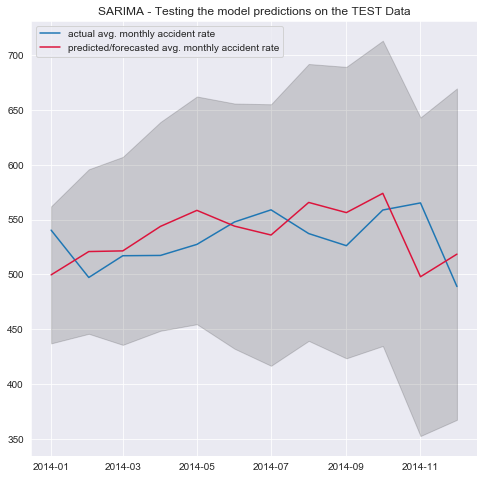

In [34]:
###LETS FORECAST
##Credits: https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

# Forecast on the test/out-of-sample data
n_periods = 12
fitted, confint = model_uk.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(df_test_uk.index[0], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(df_test_uk, label = 'actual avg. monthly accident rate')
plt.plot(fitted_series, color='crimson', label = 'predicted/forecasted avg. monthly accident rate')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA - Testing the model predictions on the TEST Data")
plt.legend(loc='upper left', fontsize=10)
plt.show()

In [35]:
##How accurate is our model
def forecast_accuracy(forecast, actual):
    mae = np.mean(np.abs(forecast - actual))  # MAE
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    print('Mean Absolute Percentage Error (MAPE):', mape, '\n',
         'Mean Absolute Error (MAE):', mae)

In [36]:
forecast_accuracy(fitted, df_test_uk.values)

Mean Absolute Percentage Error (MAPE): 0.05185862850304892 
 Mean Absolute Error (MAE): 27.31039016371171


#### - Our model did a good job on the test data, with MAPE : 5 %, meaning that the predicted values differ by 5 % from the actual values 

### - Lets train the whole dataset and use it to forecast 2 years into the future

In [37]:
###LET's PERFORM CROSS-VAL ON THE WHOLE DATASET
###GRID SEARCH FOR THE BEST P;D;Q VALUES FOR uk_TRAIN DATASET time series dataset

model_uk = pm.auto_arima(uk_agg['mean'], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=4, max_q=2, # maximum p and q
                      m=12,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # Set Seasonlity TRUE since, we have seasonality in our dataset
                      start_P=0, 
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

model_uk.summary()

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,1,1,12) [intercept=True]; AIC=1081.494, BIC=1094.858, Time=1.000 seconds
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=True]; AIC=1159.833, BIC=1165.178, Time=0.015 seconds
Fit ARIMA(1,1,0)x(1,1,0,12) [intercept=True]; AIC=1110.909, BIC=1121.601, Time=0.415 seconds
Fit ARIMA(0,1,1)x(0,1,1,12) [intercept=True]; AIC=1080.774, BIC=1091.465, Time=0.472 seconds
Near non-invertible roots for order (0, 1, 1)(0, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=False]; AIC=1157.840, BIC=1160.513, Time=0.013 seconds
Fit ARIMA(1,1,1)x(0,1,0,12) [intercept=True]; AIC=1154.687, BIC=1165.378, Time=0.126 seconds
Fit ARIMA(1,1,1)x(1,1,1,12) [intercept=True]; AIC=1075.503, BIC=1091.540, Time=1.519 seconds
Near non-invertible roots for order (1, 1, 1)(1, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit ci

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  120
Model:             SARIMAX(1, 1, 1)x(0, 1, [1, 2], 12)   Log Likelihood                -529.886
Date:                                 Sat, 27 Jun 2020   AIC                           1071.772
Time:                                         00:38:13   BIC                           1087.809
Sample:                                              0   HQIC                          1078.274
                                                 - 120                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1244      0.220      0.565      0.572      -0.307       0.556
ar.L1          0.4489      0.227      1.981      0.048       0.005       0.893
ma.L1         -0.7599      0.186     -4.087      0.000      -1.124      -0.395
ma.S.L12      -1.4527      2.686     -0.541      0.589      -6.717       3.812
ma.S.L24       0.4674      1.166      0.401      0.689      -1.819       2.754
sigma2       796.4854   2146.059      0.371      0.711   -3409.712    5002.683
===================================================================================
Ljung-Box (Q):                       22.33   Jarque-Bera (JB):               130.99
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               2.82   Skew:                             0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [38]:
# Forecast 2 Years into the future
n_periods = 24
fitted, confint = model_uk.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(uk_agg.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

In [39]:
def plot_sarima_forecast(lower_series, upper_series, fitted_series, df):
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=lower_series.index, y=lower_series.values, mode='lines', line_color='darkgrey', showlegend = False))
    fig.add_trace(go.Scatter(x=upper_series.index, y=upper_series.values, fill='tonexty', mode='lines', line_color='darkgrey', showlegend = False))
    fig.add_trace(go.Scatter(x = fitted_series.index, y = fitted_series.values, line_color = 'firebrick', name = 'Forecast'))
    fig.add_trace(go.Scatter(x = df.index, y = df['mean'], line_color = 'cadetblue', name = 'Actual'))
    
    fig.update_layout(title_text="<b> Accident rates in UK, 2009 - 2014, + Forecasted accident rate, 2015 - 2016 <b>", 
                      xaxis_title="<b> Date <b>", yaxis_title="<b> Monthly Average <b>", 
                      font=dict(size=12, color="darkslategray"))
    
    fig.update_xaxes(rangeslider_visible=True, rangeselector=dict(buttons=list([
        dict(count=1, label="1m", step="month", stepmode="backward"), 
        dict(count=6, label="6m", step="month", stepmode="backward"),
        dict(count=1, label="YTD", step="year", stepmode="todate"), 
        dict(count=1, label="1y", step="year", stepmode="backward"), dict(step="all")])))
    
    fig.show()

In [40]:
plot_sarima_forecast(lower_series, upper_series, fitted_series, uk_agg)

### - SARIMA 2 


### Lets use 2009- 2014 dataset without 2005 - 2007, due to the 2008 time gap in the dataset and see if the results ( i.e. AIC) will be better

In [41]:
uk_agg_2009 = uk_agg.loc['2009-01-01':].copy()

In [42]:
uk_agg_2009.shape

(72, 1)

In [43]:
plot_accident_rate(uk_agg_2009, '2009 - 2014')

### - First, is to check if the data is still 'Non-Stationary'

#### Note: we didnt decompose the data because we already know that our data has a trend and a seasonal repeated pattern

In [44]:
# ADF Test
result = adfuller(uk_agg_2009['mean'].values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -3.2779955407732717
p-value: 0.01589118747109346


 From the above p-value result, It is shown that out Data is "STATIONARY", so no need to difference the data.

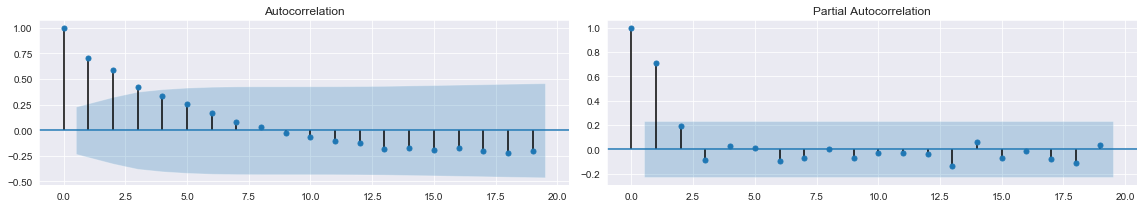

In [45]:
fig,axes = plt.subplots(1,2,figsize=(16,3))
smt.graphics.tsa.plot_acf(uk_agg_2009['mean'], ax=axes[0])
smt.graphics.tsa.plot_pacf(uk_agg_2009['mean'], ax=axes[1])
plt.tight_layout()

- From the above ACF plot, 1st and 2nd lags are above the significant line, this means the MA terms for our model can be 2; while the PACF plot, shows that 1 AR term (only the 1st lag is above the significant line) is needed for the model.



- As always, a grid search will be performed to evaluate and get the best MA and AR terms for the model.

### Grid Search for the best p,d,q values and use it to forecast

In [46]:
###GRID SEARCH FOR THE BEST P;D;Q VALUES FOR uk_
model_uk = pm.auto_arima(uk_agg_2009['mean'], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=12,              # frequency of series
                      d=0,           # 'd' == 0 ##NO DIFFERENCING
                      seasonal=True,   # Set Seasonlity TRUE since, we have seasonality in our dataset
                      start_P=0, 
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

model_uk.summary()

Performing stepwise search to minimize aic
Fit ARIMA(1,0,1)x(0,1,1,12) [intercept=True]; AIC=630.830, BIC=641.302, Time=0.482 seconds
Fit ARIMA(0,0,0)x(0,1,0,12) [intercept=True]; AIC=714.624, BIC=718.813, Time=0.012 seconds
Fit ARIMA(1,0,0)x(1,1,0,12) [intercept=True]; AIC=643.881, BIC=652.259, Time=0.239 seconds
Fit ARIMA(0,0,1)x(0,1,1,12) [intercept=True]; AIC=650.282, BIC=658.660, Time=0.335 seconds
Near non-invertible roots for order (0, 0, 1)(0, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(0,0,0)x(0,1,0,12) [intercept=False]; AIC=714.268, BIC=716.362, Time=0.011 seconds
Fit ARIMA(1,0,1)x(0,1,0,12) [intercept=True]; AIC=666.089, BIC=674.466, Time=0.214 seconds
Fit ARIMA(1,0,1)x(1,1,1,12) [intercept=True]; AIC=629.096, BIC=641.662, Time=0.682 seconds
Near non-invertible roots for order (1, 0, 1)(1, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
F

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                   72
Model:             SARIMAX(1, 0, 1)x(0, 1, [1, 2], 12)   Log Likelihood                -307.062
Date:                                 Sat, 27 Jun 2020   AIC                            626.124
Time:                                         00:39:12   BIC                            638.690
Sample:                                              0   HQIC                           631.039
                                                  - 72                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.1068      1.742     -1.209      0.227      -5.521       1.308
ar.L1          0.8230      0.127      6.487      0.000       0.574       1.072
ma.L1         -0.2457      0.221     -1.110      0.267      -0.680       0.188
ma.S.L12      -1.9423    757.854     -0.003      0.998   -1487.310    1483.425
ma.S.L24       0.9472    719.054      0.001      0.999   -1408.372    1410.267
sigma2       596.5227   4.53e+05      0.001      0.999   -8.87e+05    8.89e+05
===================================================================================
Ljung-Box (Q):                       26.23   Jarque-Bera (JB):                32.46
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.40   Skew:                            -0.53
Prob(H) (two-sided):                  0.46   Kurtosis:                         6.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- The **above model AIC (626)** is lower than the earlier model trained on the whole dataset, this shows that **this model is most accurate and more appropriate in predicting out-of-sample data than the model built on the whole dataset.**

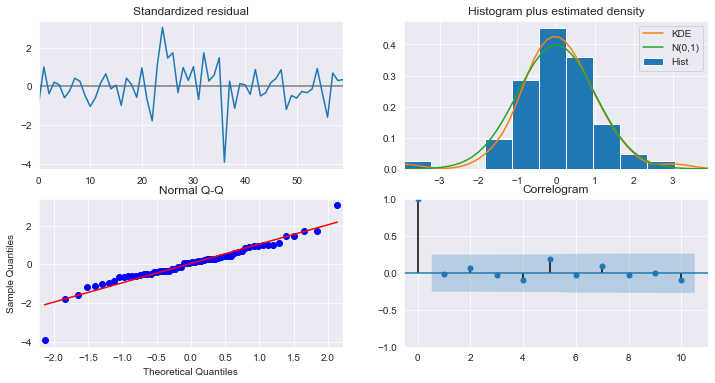

In [47]:
##check the accuracy of the linear model
model_uk.plot_diagnostics(figsize=(12,6))
plt.show()

Note: The above plots is very similar to the earlier model's plots, and it also satisfy the assumption of linear regressive models, except for the abrupt spikes seen in the first plot.

In [48]:
# Forecast on the test/out-of-sample data
n_periods = 24
fitted, confint = model_uk.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(uk_agg_2009.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

In [49]:
plot_sarima_forecast(lower_series, upper_series, fitted_series, uk_agg_2009)

In [50]:
print(fitted[-12:].sum() / uk_agg_2009[-12:].sum()) # Accident rate after 2 years
print((fitted[-12:].sum() - uk_agg_2009[-12:].sum()) / 2) # Avg accident drop each year

mean    0.979367
dtype: float64
mean   -65.848094
dtype: float64


### Major results from the forecast 

- Accident rate is said to have drop by **9.7%** after 2 years
- The average number of Casualties due to road accidents each year (within the 2 years) will be **65** less than the previous year.

### 2. Facebook Prophet -  Forecast UK Accident rates based on Number of Casualties

In [51]:
df_agg = df_uk[['Date', 'Number_of_Casualties']].copy()

In [52]:
df_uk_agg = df_agg.groupby(['Date']).agg(['sum']).sort_values(by = 'Date')

In [53]:
#droplevel
df_uk_agg.columns  = df_uk_agg.columns.droplevel(1)

#resampling (aggregating the dates) for each month
uk_agg = df_uk_agg.resample('MS').agg(['mean'])

##lets interpolate for the whole year of 2008, since 2008 is missing
uk_agg = uk_agg.interpolate().asfreq('MS')

#droplevel
uk_agg.columns  = uk_agg.columns.droplevel(1)

In [54]:
df_train = uk_agg.loc['2005-01-01':'2013-12-01']
df_test = uk_agg.loc['2014-01-01':'2014-12-01']

### What is Facebook Prophet?


- Facebook Prophet is an open source library published by Facebook that is based on decomposable (trend+seasonality+holidays) models. 

  - **Trend** models non periodic changes in the value of the time series.
  - **Seasonality** is the periodic changes like daily, weekly, or yearly seasonality.
  - **Holidays** effect which occur on irregular schedules over a day or a period of days.
  - **Error terms** account for any unusual changes not accommodated by the model.
  

- We will be setting two hyperparameters for our Prophet model:

     
  - Also, we will set the **seasonality_mode (~ this parameter indicates how your seasonality components should be integrated with the predictions.) to multplicative.**  This is because the seasonality trend **will not be “constant”** over the entire period, As we have observed and expect that the rate of road accident would be **dropping/reducing over time**. In a case like this, multiplicative will be used to increase the importance of the seasonalities over time.
  
  
  - we also set yearly_seasonality to True 

In [55]:
###The input to Prophet is always a dataframe with two columns: ds and y

df_train['ds'] = df_train.index
df_train['y'] = df_train.Number_of_Casualties
df_train.drop(['Number_of_Casualties'],axis = 1, inplace = True)

In [56]:
#fit the model on the train data
##Note that the hyperparmeters included
m = Prophet(yearly_seasonality = True, seasonality_mode='multiplicative', seasonality_prior_scale=0.1).fit(df_train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [57]:
df_test.shape

(12, 1)

In [58]:
df_test.reset_index(inplace = True)

In [59]:
df_test.columns = ['ds', 'y']

In [60]:
#make a prediction on the test data
forecast = m.predict(df_test)

In [61]:
y_pred = forecast['yhat'] ##'yhat' is the predicted value of df_test

In [62]:
y_pred.index =df_test['ds']

In [63]:
import datetime

fig = plot_plotly(m, forecast)  # This returns a plotly Figure
fig.add_scatter(x=df_test['ds'], y= df_test['y'], mode='lines', name = 'Actual Number of Casualties')

fig.update_layout(xaxis_range=[datetime.datetime(2014, 1, 1),
                               datetime.datetime(2014, 12, 1)], 
                  title_text="<b> Predicted vs Actual Number of Casualties in UK, 2014 <b>",
                 xaxis_title="<b> Date <b>", yaxis_title="<b> number of Casualties <b>",
                 font=dict(family="Courier New, monospace", size=18, color="#7f7f7f"))
iplot(fig)

In [64]:
#lets calculate the average mean error in percent between forecasted value and the actual value
fb_mape_loss = np.mean(np.abs(df_test.y.values - y_pred)/np.abs(df_test['y'].values))
##calculate Mean Absolute Error
fb_mae_loss = np.mean(np.abs(df_test.y.values - y_pred))

In [65]:
print('Mean Absolute Percentage Loss: ', fb_mape_loss)#
print('Mean Absolute Error: ', fb_mae_loss)

Mean Absolute Percentage Loss:  0.017951166796634232
Mean Absolute Error:  9.453868068087113


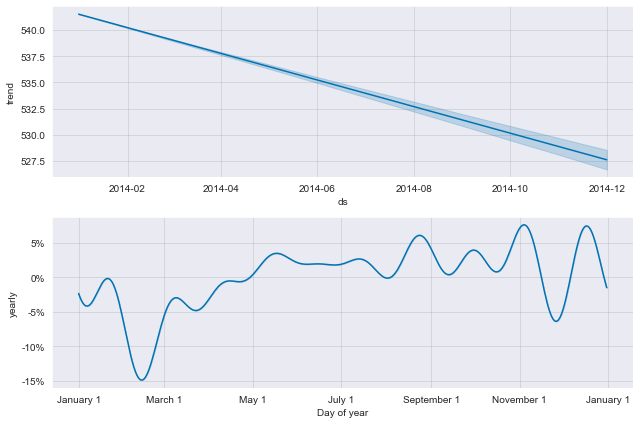

In [66]:
##lets see the components of the forecast i.e. trend and the seasonality
fig = m.plot_components(forecast)

### - Lets Forecast 2 years into the future

In [67]:
df_agg = uk_agg.copy()

In [68]:
df_agg.reset_index(inplace = True)

In [69]:
df_agg.columns = ['ds', 'y']

In [70]:
##lets fit the model on the whole data
fp_model = Prophet(yearly_seasonality = True, seasonality_mode='multiplicative', seasonality_prior_scale=0.1).fit(df_agg)

future = fp_model.make_future_dataframe(periods=24, freq='M') # Making new rows for future

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [71]:
##take only the forcast (2) years
future[-24:] += pd.DateOffset(1) # this will change the monthly date from 01-31 TO 01-01, i.e month at the first day

In [72]:
future_pred = fp_model.predict(future)

In [73]:
forecast_years = future_pred[-24:]

In [74]:
fig = plot_plotly(fp_model, forecast_years)  # This returns a plotly Figure
fig.add_scatter(x=df_agg['ds'], y= df_agg['y'], mode='lines', name = 'Actual')

fig.update_layout(title_text="<b> Accident rates in UK, 2005 - 2014 (+ 2015 - 2016 Forecast)<b>",
                 xaxis_title="<b> Date <b>", yaxis_title="<b> number of Casualties <b>",
                 font=dict(family="Courier New, monospace", size=15, color="darkslategray"))
iplot(fig)

In [75]:
print(forecast_years[-12:]['yhat'].sum() / uk_agg[-12:].sum()) # Accident rate after 2 years
print((forecast_years[-12:]['yhat'].sum() - uk_agg[-12:].sum()) / 2) # average accident rate to drop each year

Number_of_Casualties    0.948543
dtype: float64
Number_of_Casualties   -164.219601
dtype: float64


### Major results from the 2 years forecast 

- Accident rate is said to drop by **9.4%** after two years
- Based on our model (Facebook Prophet), Number of Casualties due to road accidents each year for the next two years is said to be **164** less than the previous year.

### 3.  LSTM - Long Short Term Memory - Forecast accident rates in UK based on Number of Casualties

- Here, We will try to see if is possible to use various forms of LSTM to forecast the accident rates in UK based on the available dataset.

  - **LSTM**
  - GRU
  - Bidirectional LSTM
  - Convolutional LSTM

In [76]:
df_uk_lstm = df_uk[['Date', 'Number_of_Casualties']].copy()

In [77]:
df_uk_agg = df_uk_lstm.groupby(['Date']).agg(['sum']).sort_values(by = 'Date')

In [78]:
df_uk_agg.head()

,Number_of_Casualties
,sum
Date,
2005-01-01,441
2005-01-02,814
2005-01-03,793
2005-01-04,636
2005-01-05,719


In [79]:
df_uk_agg.columns  = df_uk_agg.columns.droplevel(1)

In [80]:
#resampling (aggregating the dates) for each month
uk_agg = df_uk_agg.resample('MS').agg(['mean'])

##lets interpolate for the whole year of 2008, since 2008 is missing
uk_agg = uk_agg.interpolate().asfreq('MS')

#droplevel
uk_agg.columns  = uk_agg.columns.droplevel(1)

In [81]:
uk_agg.shape

(120, 1)

In [82]:
uk_agg.isnull().sum()

Number_of_Casualties    0
dtype: int64

In [83]:
###split the data into TEST AND TRAIN DATASET 
df_train = uk_agg.loc['2005-01-01':'2013-12-01']
df_test = uk_agg.loc['2014-01-01':'2014-12-01']

In [ ]:
###

### Data Preprocessing


- Standard Scaler reconstructs or scales the data (all features) to have a zero mean and a standard deviation of one. Firstly by subtracting the mean it brings the values around 0 – so has zero mean. Secondly, it divides the values by standard deviation thereby ensuring that the resulting distribution is standard with a mean of 0 and standard deviation of 1. **[reference](http://rajeshmahajan.com/standard-scaler-v-min-max-scaler-machine-learning/).**


- Note that we normalize the training data (i.e. fit and transform), and use its summary statistics to normalize the validation and test data (i.e. only transform) (for normalization, these statistics are the mean and variances of each feature). ***This is because the test data should be completely unseen to anything during the modeling.***

In [84]:
#instantiate the standardScaler
scaler = StandardScaler()

In [85]:
print(df_train.shape) ##5 years training data
print(df_test.shape) ##1 year test data 

(108, 1)
(12, 1)


In [86]:
#normalize the data to have mean == 0; and Std == 1
scaler.fit(df_train)
train_scaled = scaler.transform(df_train)
test_scaled = scaler.transform(df_test)

In [87]:
print(train_scaled.shape)
print(test_scaled.shape)

(108, 1)
(12, 1)


### - What is LSTM?

- Long Short-term Memory (LSTM) networks are a distinct type of **Recurrent Neural Networks.** They are able to learn long-term dependencies and are very popular for working with sequential data such as time-series data. The major innovation of LSTM is its **memory cell** which essentially acts as an accumulator of the state information. The cell is accessed, written and cleared by several self-parameterized controlling gates.



 
- The long-short-term memory cell uses ***an input gate; a forget gate and an output gate (a simple multilayer perceptron).*** These gates define whether the data can pass through or not depending on the data’s priority. The gates also enable the network to learn what to save, what to forget, what to remember, what to pay attention, and what to output. The cell state and hidden state are used in gathering data for processing in the next state.




Resources:

[resource 1](https://www.michaelphi.com/illustrated-guide-to-lstms-and-grus-a-step-by-step-explanation/):

[resource 2](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) :

Shi et al., 2015, 

[Yamak et al., 2019](https://doi.org/10.1145/3377713.3377722)


***- After numerous trials and errors ---> For LSTM; GRU; Bidirectional LSTM, we will set timesteps to '3', i.e. the model will look back 3 times (months) before predicting the next value (4th month).***

In [88]:
##Define a function that split column into discrete timesteps
###Credits: https://mc.ai/how-to-develop-lstm-models-for-time-series-forecasting/

# split the sequence into samples
def split_sequences(sequences, n_steps):
    X, y = [], []
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [89]:
##use to validate the predicted values
forecast_lstm = df_test.loc['2014-04-01':'2014-12-01']
forecast_lstm.reset_index(inplace = True)

In [90]:
forecast_lstm.shape

(9, 2)

In [91]:
#no of timesteps == 3;
timesteps = 3
x_train, y_train = split_sequences(train_scaled, timesteps)
x_test, y_test = split_sequences(test_scaled, timesteps)

In [92]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(105, 3, 1) (105, 1)
(9, 3, 1) (9, 1)


In [83]:
#print(y_test)

In [93]:
#LSTM parameters
lr = 0.0001
adam = optimizers.Adam(lr)

#Building the LSTM model
##x_train.shape[1] -- Timesteps, x_train.shape[2] -- Features
lstm = Sequential()
#lstm.add(LSTM(32, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True))
lstm.add(LSTM(32, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=False))
#lstm.add(LSTM(32, activation='relu', return_sequences=False))
#lstm.add(Dropout(0.1))
lstm.add(Dense(100))
#stacked_lstm.add(Dropout(0.1))
lstm.add(Dense(1))

lstm.compile(loss='mse',optimizer=adam)
lstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                4352      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               3300      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 7,753
Trainable params: 7,753
Non-trainable params: 0
_________________________________________________________________


In [94]:
lstm_history = lstm.fit(x_train, y_train, validation_split=0.1, 
                        shuffle=False, batch_size=10, epochs=400, verbose =0)

In [95]:
def plot_history(history):
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.title('LSTM - train vs validation loss')
    plt.ylabel('loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper right')

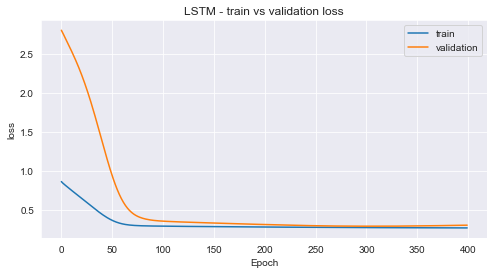

In [96]:
plot_history(lstm_history)

In [97]:
x_pred = lstm.predict(x_test, verbose=0)

In [98]:
x_pred = scaler.inverse_transform(x_pred)

In [99]:
casualties_forecast_test = [x[0] for x in x_pred]

In [100]:
def forecast_plot(actual, forecast):
    fig = go.Figure()
    fig.add_scatter(x=actual['Date'], y=actual['Number_of_Casualties'], mode='lines+markers', name = 'Actual')
    fig.add_scatter(x=actual['Date'], y= forecast, mode='lines+markers', name = 'Forecast')
    fig.update_layout(title_text="<b> Actual VS Forecast <b>", 
                      xaxis_title="<b> Date <b>", yaxis_title="<b> number of Casualties <b>")
    fig.show()

In [101]:
forecast_plot(forecast_lstm, casualties_forecast_test)

###  After numerous trials and tweaks, we realize the LSTM model did not perform well on predicting the un-seen data. This is probably due to the ***SMALL SIZE*** of our dataset (~120 after aggregating the timeseries to monthly data).

In [102]:
y_test_inverse = scaler.inverse_transform(y_test)

In [103]:
##calculate the MAE and MAPE
def forecast_error(y_test_inverse, x_pred):
    mae_loss = np.mean(np.abs(y_test_inverse - x_pred))
    mape_loss = np.mean(np.abs(y_test_inverse - x_pred)/np.abs(y_test_inverse))
    return mae_loss, mape_loss

In [104]:
#lets calculate the average mean error between forecasted value and the actual value
lstm_mae_loss, lstm_mape_loss = forecast_error(y_test_inverse, x_pred)

In [105]:
print('Mean Absolute Error:', lstm_mae_loss)
print('Mean Absolute Percentage Error:', lstm_mape_loss)

Mean Absolute Error: 21.546066054477485
Mean Absolute Percentage Error: 0.04211369299916566


### GRU - Gated Recurrent Units

- GRU --- The Gated Recurrent Unit, just like the LSTM, is a Recurrent Neural Network. It, however, has a less complicated structure compared to LSTM. It lacks an output gate but has an update z and a reset gate r. These gates are vectors which decide what information should be passed to the output.


Resources:

[resource](doi:10.3390/en10101453)

In [106]:
#GRU parameters
lr = 0.00001
adam = optimizers.Adam(lr)

#Building the GRU model
##x_train.shape[1] -- Timesteps, x_train.shape[2] -- Features
gru = Sequential()
gru.add(GRU(128, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=False))
#gru.add(GRU(32, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True))
#gru.add(GRU(12, activation='relu', return_sequences=False))
gru.add(Dense(50))
#gru.add(Dropout(0.1))
gru.add(Dense(1))

gru.compile(loss='mse',optimizer=adam)
gru.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 128)               49920     
_________________________________________________________________
dense_3 (Dense)              (None, 50)                6450      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total params: 56,421
Trainable params: 56,421
Non-trainable params: 0
_________________________________________________________________


In [107]:
gru_history = gru.fit(x_train, y_train, validation_split=0.1, 
                      shuffle=False, batch_size=10, epochs=600, verbose =0)

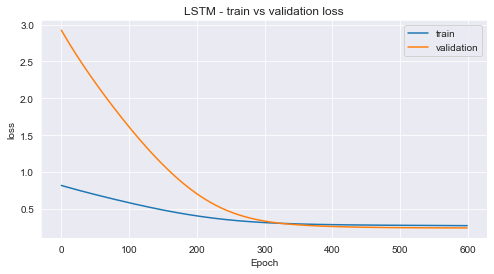

In [108]:
plot_history(gru_history)

In [109]:
x_pred = gru.predict(x_test, verbose=0)

In [110]:
x_pred = scaler.inverse_transform(x_pred)

In [111]:
casualties_forecast_gru = [x[0] for x in x_pred]

In [112]:
forecast_plot(forecast_lstm, casualties_forecast_gru)

### Also, due to the **SMALL SIZE** of the dataset, the GRU didnt perform as we had expected........

In [113]:
y_test_inverse = scaler.inverse_transform(y_test)

In [114]:
#lets calculate the average mean error between forecasted value and the actual value
gru_mae_loss, gru_mape_loss = forecast_error(y_test_inverse, x_pred)

In [115]:
print('Mean Absolute Error:', gru_mae_loss)
print('Mean Absolute Percentage Error:', gru_mape_loss)

Mean Absolute Error: 20.87228675760248
Mean Absolute Percentage Error: 0.04047439093999491


### Bidirectional LSTM 

- Bidirectional LSTMs have two recurrent components, a forward recurrent component and a backward recurrent component. This structure allows the networks to have both backward and forward information about the sequence at every time step, Using bidirectional will run your inputs in two ways, one from past to future and one from future to past and what differs this approach from unidirectional is that in the LSTM that runs backward, preserve information from the future and using the two hidden states combined you are able in any point in time to preserve information from both past and future.


Resources:

[resource](https://medium.com/@raghavaggarwal0089/bi-lstm-bc3d68da8bd0)

[resource](https://towardsdatascience.com/time-series-forecasting-with-deep-stacked-unidirectional-and-bidirectional-lstms-de7c099bd918)

In [116]:
#LSTM parameters
lr = 0.0001
adam = optimizers.Adam(lr)

# define model
bidirectional_lstm = Sequential()
bidirectional_lstm.add(Bidirectional(LSTM(32, return_sequences=False, activation='relu'), input_shape=(x_train.shape[1], x_train.shape[2])))
#bidirectional_lstm.add(Bidirectional(LSTM(32, return_sequences=True, activation='relu'), input_shape=(x_train.shape[1], x_train.shape[2])))
#bidirectional_lstm.add(Bidirectional(LSTM(16, return_sequences=True, activation='relu'), input_shape=(x_train.shape[1], x_train.shape[2])))
#bidirectional_lstm.add(Bidirectional(LSTM(8, return_sequences=False, activation='relu')))
#bidirectional_lstm.add(Dense(100))
#bidirectional_lstm.add(Dropout(0.1))
bidirectional_lstm.add(Dense(1))
bidirectional_lstm.compile(optimizer= adam, loss='mse')

bidirectional_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 64)                8704      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 8,769
Trainable params: 8,769
Non-trainable params: 0
_________________________________________________________________


In [117]:
bidirectional_lstm_history = bidirectional_lstm.fit(x_train, y_train, validation_split=0.1, 
                                        shuffle=False, batch_size = 10, epochs=400, verbose =0)

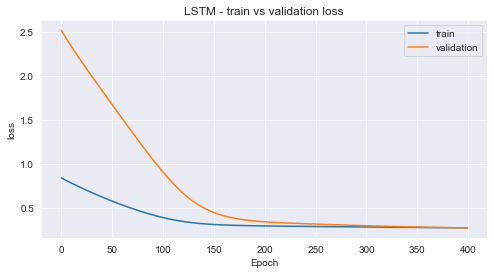

In [118]:
plot_history(bidirectional_lstm_history)

In [119]:
x_pred = bidirectional_lstm.predict(x_test, verbose=0)

In [120]:
x_pred = scaler.inverse_transform(x_pred)

In [121]:
casualties_forecast_bilstm = [x[0] for x in x_pred]

In [122]:
forecast_plot(forecast_lstm, casualties_forecast_bilstm)

### After Numerous tweaks and trials......we couldn't optimize the Bi-LSTM to do better than the others....due to the SMALL SIZE Data.....

In [123]:
y_test_inverse = scaler.inverse_transform(y_test)

In [124]:
#lets calculate the average mean error between forecasted value and the actual value
bilstm_mae_loss, bilstm_mape_loss = forecast_error(y_test_inverse, x_pred)

In [125]:
print('Mean Absolute Error:', bilstm_mae_loss)
print('Mean Absolute Percentage Error:', bilstm_mape_loss)

Mean Absolute Error: 21.405632297967063
Mean Absolute Percentage Error: 0.04180850387659383


### last but not the least.......


### - Convolutional LSTM


- [Shi et al., 2015]  developed a Conv-LSTM that handles spatiotemporal data, in which all inputs and gates of this LSTM are 3-D Tensors with ability to encode spatial information. ***This distinguishing feature entails that all the inputs X1; : : : ;Xt, cell outputs C1; : : : ; Ct, hidden states H1; : : : ;Ht, and gates it; ft; ot of the ConvLSTM are 3D tensors whose last two dimensions are spatial dimensions (rows and columns).*** To get a better picture of the inputs and states, they imagined them as vectors standing on a spatial grid. The ConvLSTM determines the future state of a certain cell in the grid by the inputs and past states of its local neighbors.


- Based on their experiments they concluded that  ConvLSTM network captures spatiotemporal correlations better and consistently outperforms FC-LSTM for precipitation nowcasting.


- Lets see if it can capture the underlying patterns in our SMALL dataset

**[Source](https://mc.ai/how-to-develop-lstm-models-for-time-series-forecasting/)**

The ConvLSTM was developed for reading two-dimensional spatial-temporal data, but can be adapted for use with univariate time series forecasting.

The layer expects input as a sequence of two-dimensional images, therefore the shape of input data must be:

**[samples, timesteps, rows, columns, features]** 


For this project, each sample will be split into subsequences where timesteps will become the number of subsequences, or n_seq, and columns will be the number of time steps for each subsequence, or n_steps. The number of rows is fixed at 1 as we are working with one-dimensional data.

In [126]:
##Credits: https://mc.ai/how-to-develop-lstm-models-for-time-series-forecasting/
##first step -- split input to sequences, just like before
#no of timesteps == 4; i.e 4 months will predict the following 5th day,
##the reason we change from 3 to 4, is because we are still going to break the "sequences" into "sub-sequences"

timesteps = 4
x_train, y_train = split_sequences(train_scaled, timesteps)
x_test, y_test = split_sequences(test_scaled, timesteps)

In [127]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(104, 4, 1) (104, 1)
(8, 4, 1) (8, 1)


In [128]:
###Here we will split the timesteps to "2" subsequences
###then now the no of timesteps will be the no of subsequences i.e. 2
### and column will be number of timesteps in each subsequences i.e. 2
###shape == [samples, timesteps, rows, column, features]

timesteps = 2
columns = 2
rows = 1 
features = 1

x_train = x_train.reshape((x_train.shape[0], timesteps, rows, columns, features))
x_test = x_test.reshape((x_test.shape[0], timesteps, rows, columns, features))

In [129]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(104, 2, 1, 2, 1) (104, 1)
(8, 2, 1, 2, 1) (8, 1)


In [130]:
#ConvLSTM parameters
lr = 0.0001
adam = optimizers.Adam(lr)

##ConvLSTM Model
conv_lstm = Sequential()
#conv_lstm.add(ConvLSTM2D(filters=128, kernel_size=(1,2), activation='relu', input_shape=(timesteps, 1, columns, features), return_sequences = True))
#conv_lstm.add(ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu', input_shape=(timesteps, 1, columns, features), return_sequences = True))
conv_lstm.add(ConvLSTM2D(filters=128, kernel_size=(1,2), activation='relu', input_shape=(timesteps, 1, columns, features), return_sequences = True))
#conv_lstm.add(ConvLSTM2D(filters=16, kernel_size=(1,2), activation='relu', input_shape=(timesteps, 1, columns, features), return_sequences = True))
#conv_lstm.add(ConvLSTM2D(filters=8, kernel_size=(1), activation='relu', input_shape=(timesteps, 1, columns, features)))
conv_lstm.add(Flatten())
conv_lstm.add(Dense(100))
conv_lstm.add(Dense(1))
conv_lstm.compile(loss='mse',optimizer=adam, metrics = ['accuracy'])
conv_lstm.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_1 (ConvLSTM2D)  (None, 2, 1, 1, 128)      132608    
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)               25700     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 101       
Total params: 158,409
Trainable params: 158,409
Non-trainable params: 0
_________________________________________________________________


In [131]:
conv_lstm_history = conv_lstm.fit(x_train, y_train, validation_split = 0.1, 
                                  shuffle=False, batch_size=10, epochs=150, verbose =0)

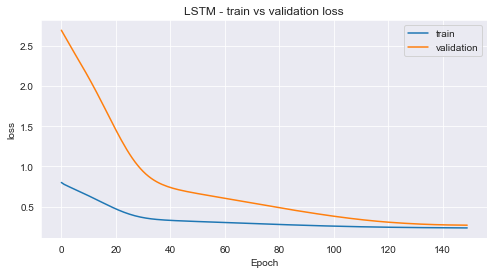

In [132]:
plot_history(conv_lstm_history)

In [133]:
x_pred = conv_lstm.predict(x_test, verbose=0)

In [134]:
x_pred = scaler.inverse_transform(x_pred)

In [135]:
casualties_forecast_convlstm = [x[0] for x in x_pred]

In [136]:
##use to validate the predicted values
forecast_conv_lstm = df_test.loc['2014-05-01':'2014-12-01']
forecast_conv_lstm.reset_index(inplace = True)

In [137]:
forecast_plot(forecast_conv_lstm, casualties_forecast_convlstm)

In [138]:
y_test_inverse = scaler.inverse_transform(y_test)

In [139]:
#lets calculate the average mean error between forecasted value and the actual value
conv_lstm_mae_loss, conv_lstm_mape_loss = forecast_error(y_test_inverse, x_pred)

In [140]:
print('Mean Absolute Error:', conv_lstm_mae_loss)
print('Mean Absolute Percentage Error:', conv_lstm_mape_loss)

Mean Absolute Error: 20.98455948368197
Mean Absolute Percentage Error: 0.04104801665540886


### Overall, after numerous trials (long hours of trial and errors) and experimenting with different LSTM architectures we couldn't optmize the LSTM to forecast correctly our time series data.

- Even though, the MAE and MAPE are low for all the LSTM, the LSTM couldn't capture the underlying patterns in our SMALL dataset. **This is likely to be due to SMALL SIZE of the dataset (120 rows after aggregating to months) or something we were not aware of during developing and optmizing the model.**



- **As a result of this, we couldn't use the LSTM to forecast the accident rates in UK because we realize it wouldn't give accurate forecast at all, since it could NOT generalize well on our test data.**